In [61]:
import pandas as pd
job_df = pd.read_csv('dataset.csv')

In [20]:
def chop_after_county(s):
    s = str(s)
    if 'COUNTY' in s:
        return s[:s.find('COUNTY') + 6] # 6 is the length of the word 'county'
    else:
        return s

job_df['upper_county'] = job_df['employer'].str.upper().apply(chop_after_county)
dfjob_df['upper_state'] = job_df['state_full_name'].str.upper()

pop = pd.read_csv('leo_population_2023.csv')

In [21]:
merged_df = pd.merge(job_df, pop[['jurisdiction', 'state', 'total_reg']],
                     left_on=['upper_county', 'upper_state'],
                     right_on=['jurisdiction', 'state'],
                     how='left')  # Use 'left' to keep all rows from job_df


In [29]:
salreg = merged_df[~merged_df['total_reg'].isna() & ~merged_df['salary_mean'].isna()]

In [86]:
len(salreg[(salreg['pay_basis_sg'].isin(['yearly', 'monthly'])) & (salreg['salary_mean'] > 10000) & salreg['is_top_official']])

28

Text(34.875, 0.5, 'mean salary on job listing')

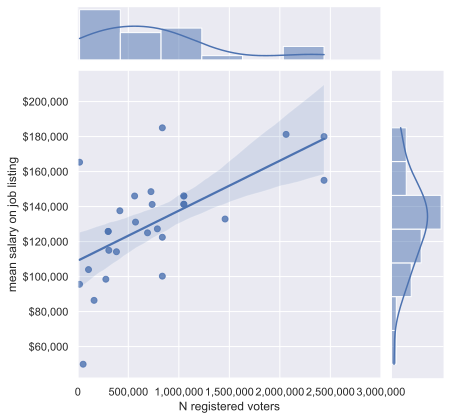

In [91]:
g = sns.jointplot(salreg[(salreg['pay_basis_sg'].isin(['yearly', 'monthly'])) & (salreg['salary_mean'] > 10000) & salreg['is_top_official']], x='total_reg', y='salary_mean', kind='reg')
g.ax_joint.set_xscale('linear')
# g.ax_joint.set_xticks([1e4, 1e5, 1e6])
# g.ax_joint.set_xticklabels(['10,000', '100,000', '1,000,000'])
g.ax_joint.set_xlim([0, 3e6])
g.ax_joint.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
g.ax_joint.set_xlabel('N registered voters')
g.ax_joint.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: f'${format(int(x), ",")}'))
g.ax_joint.set_ylabel('mean salary on job listing')

# Part D: Analysis

In [4]:
len(job_df)

1110

In [5]:
sum(job_df['salary_mean'].notna())

751

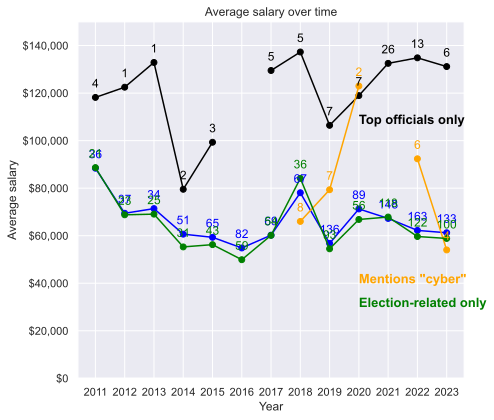

In [100]:
%config InlineBackend.figure_format = 'svg'
# plt.rcParams['figure.dpi'] = 200

# Plot salary over time, split by top official

salary_means = job_df.groupby('Year')['salary_mean'].mean()
year_counts = job_df.groupby('Year').size()

# Plot
plt.figure(figsize=(7,6))
salary_means.plot(kind='line', marker='o', color='blue')
for year, (mean, count) in enumerate(zip(salary_means, year_counts)):
    plt.annotate(str(count), (salary_means.index[year], salary_means.iloc[year]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')


def plot_subset(df, color='black', salary_col='salary_mean'):
    salary_means = df.groupby('Year')['salary_mean'].mean()
    year_counts = df.groupby('Year').size()
    
    # Plot
    salary_means.plot(kind='line', marker='o', color=color)
    for year, (mean, count) in enumerate(zip(salary_means, year_counts)):
        plt.annotate(str(count), (salary_means.index[year], salary_means.iloc[year]),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center',
                     color=color)
    
color='black'
plot_subset(job_df.loc[job_df['is_top_official']], color=color)
plt.annotate('Top officials only', (2020, 107000), weight=800, size=13, color=color)

color='orange'
plot_subset(job_df.loc[job_df['mentions_cyber']], color=color)
plt.annotate('Mentions "cyber"', (2020, 40000), weight=800, size=13, color=color)

color='green'
plot_subset(job_df.loc[job_df['election_related_only']], color=color)
plt.annotate('Election-related only', (2020, 30000), weight=800, size=13, color=color)


# Define a custom y-axis tick formatter
def currency_formatter(x, pos):
    return "${:,.0f}".format(x)

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))


plt.title('Average salary over time')
plt.ylabel('Average salary')
plt.xlabel('Year')
plt.ylim([0, 150000])
plt.grid(True)

plt.tight_layout()
plt.xticks(range(2011, 2024));
plt.show()


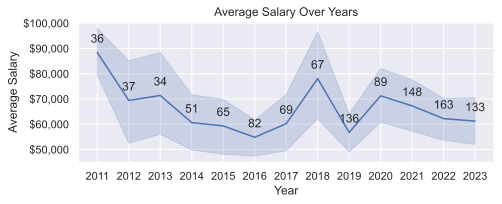

In [6]:
# with error bars

plt.figure(figsize=(7,3))
sns.lineplot(data=job_df, x="Year", y="salary_mean") # for error bar

plt.title('Average Salary Over Years')
plt.ylabel('Average Salary')
plt.xlabel('Year')
plt.grid(True)

# Annotate each point with the number of rows (job listings) for the year
for year, (mean, count) in enumerate(zip(salary_means, year_counts)):
    plt.annotate(str(count), (salary_means.index[year], salary_means.iloc[year]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.xticks(range(2011, 2024));

# Define a custom y-axis tick formatter
def currency_formatter(x, pos):
    return "${:,.0f}".format(x)

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))
plt.show()


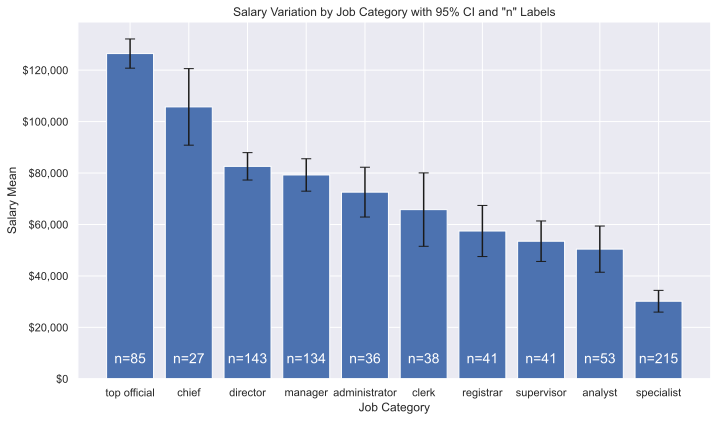

In [7]:
top_official = 'top official'
titles = ['chief', 'director', 'manager', 'administrator', 'clerk', 'registrar', 'supervisor', 'analyst', 'specialist']
for title in titles[::-1]: # reverse to prioritize catching the higher level jobs:
    job_df.loc[job_df['job_title_sg'].str.lower().str.contains(title, na=False), 'seniority'] = title
job_df.loc[job_df['is_top_official'], 'seniority'] = top_official
titles = [top_official] + titles

    

category_order = pd.CategoricalDtype(categories=titles, ordered=True)
job_df['seniority'] = job_df['seniority'].astype(category_order)

# Group the data by 'Category' and calculate the mean and standard deviation of salaries
grouped_data = job_df.groupby('seniority', observed=True)['salary_mean'].agg(['mean', 'size', 'std']).reset_index()

grouped_data['ci'] = grouped_data.apply(lambda row: sps.t.interval(0.95, row['size'] - 1, loc=row['mean'], scale=row['std'] / (row['size'] ** 0.5)), axis=1)

# Extract lower and upper CI bounds
grouped_data['ci_lower'] = grouped_data['ci'].apply(lambda x: x[0])
grouped_data['ci_upper'] = grouped_data['ci'].apply(lambda x: x[1])


# Create the bar chart with 95% CI error bars and "n" labels
plt.figure(figsize=(10, 6))
bars = plt.bar(grouped_data['seniority'], grouped_data['mean'], yerr=[grouped_data['mean'] - grouped_data['ci_lower'], grouped_data['ci_upper'] - grouped_data['mean']], capsize=5)

# Add "n" labels on top of each bar
for bar, n in zip(bars, grouped_data['size']):
    plt.text(bar.get_x() + bar.get_width() / 2, 5000, f'n={n}', ha='center', va='bottom', fontsize=14, color='w')

plt.xlabel('Job Category')
plt.ylabel('Salary Mean')
plt.title('Salary Variation by Job Category with 95% CI and "n" Labels')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))

plt.show()
